## **Walmart Sales Forecasting**

- Worked on by Weizhe XIE, Liting LI, Yue WU
- https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/overview

![截屏2024-04-01 23.13.08.png](<attachment:截屏2024-04-01 23.13.08.png>)
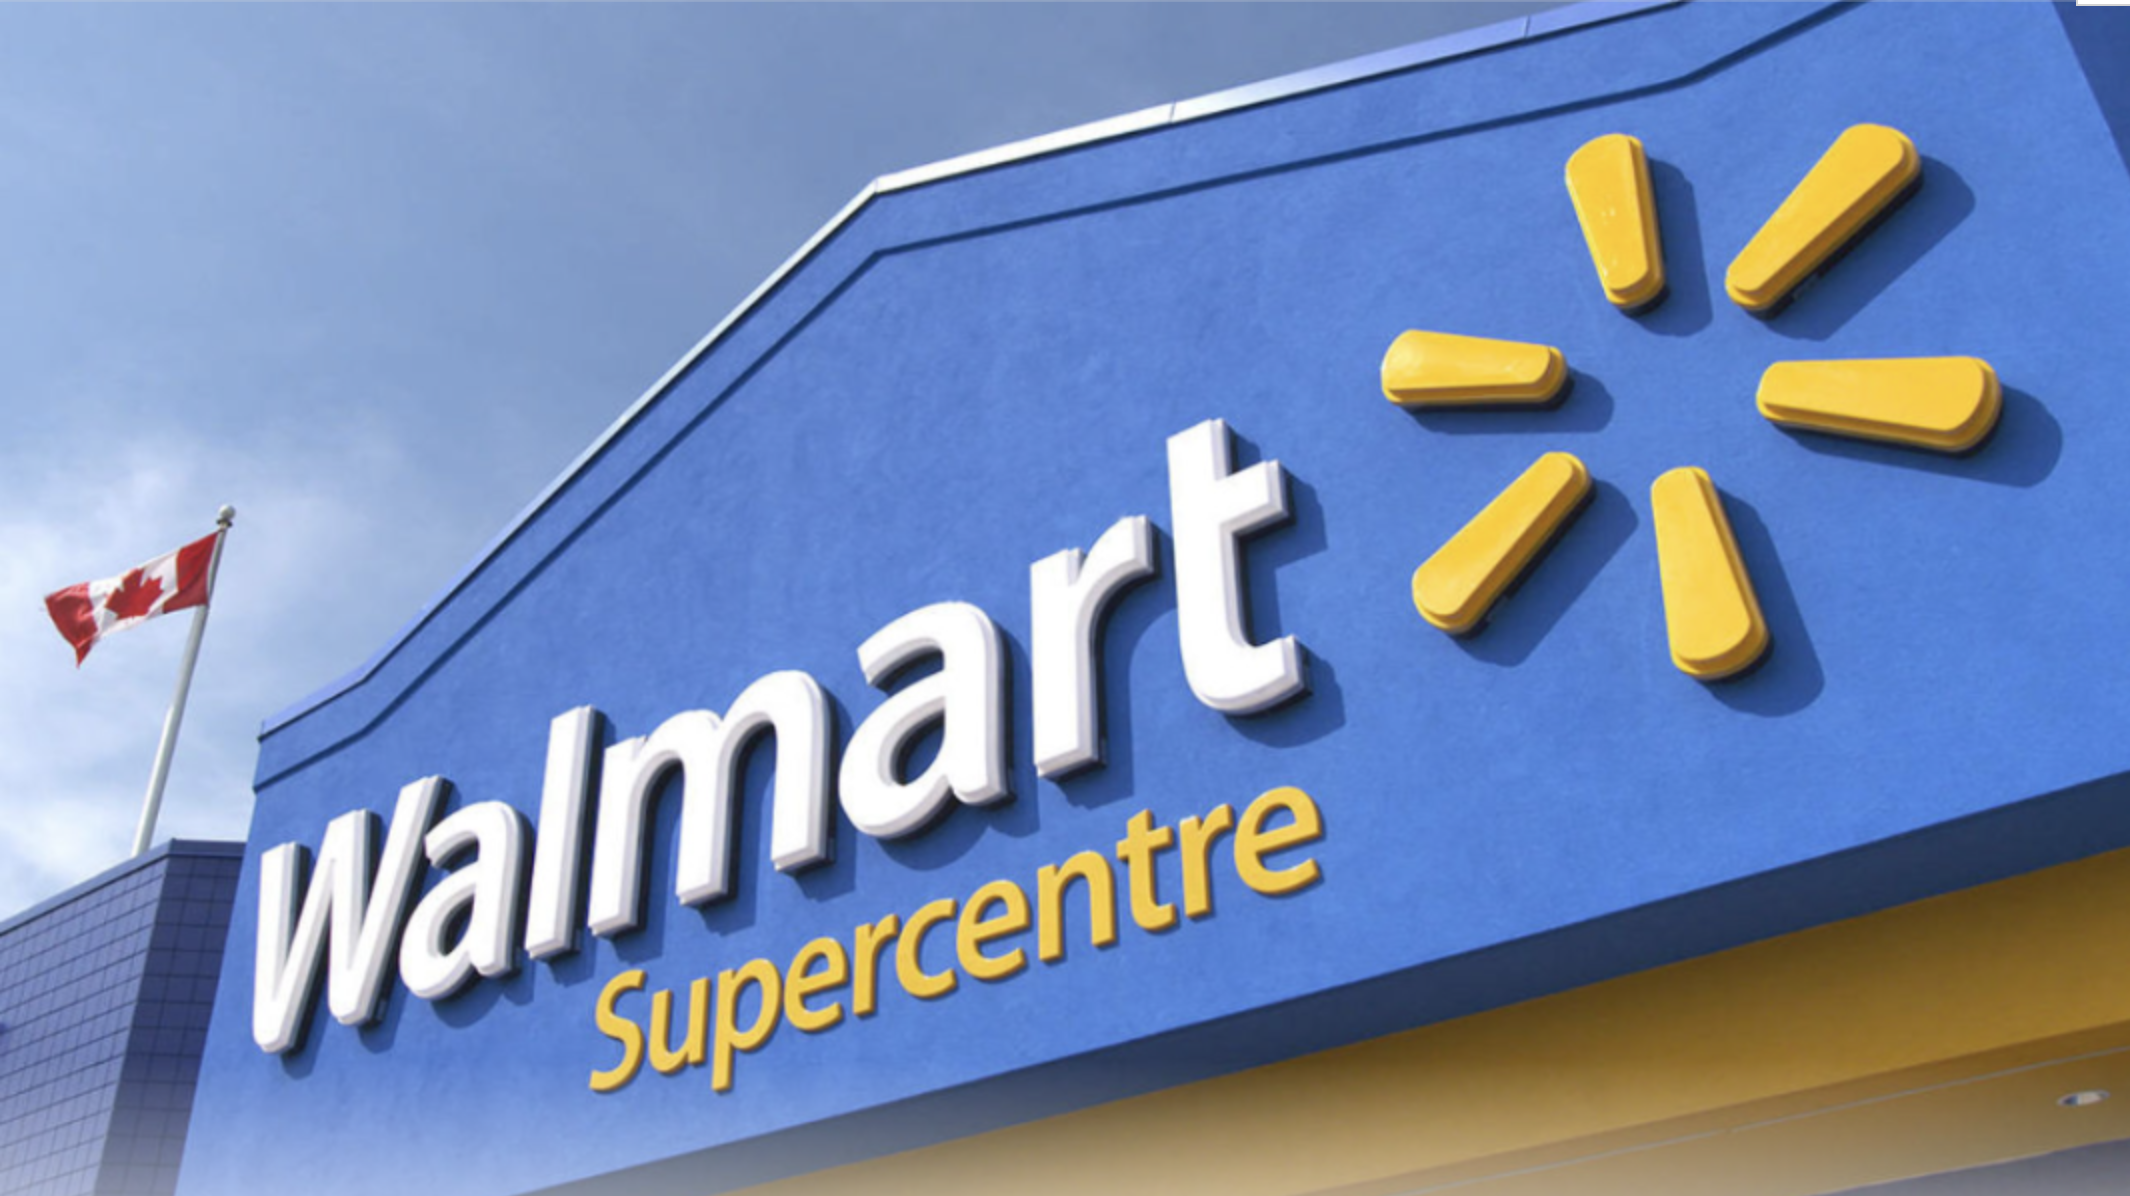

**Outline**
1. *Problem Introduction*
2. *Data Understanding*
    - Import Library
    - Data Preparation
3. *Data Visualization*
    - Exploratory Data Analysis
4. *Feature Engineering*
5. *Encoding categorical data*
6. *Machine Learning and Prediction Model*
7. *Recommendations*

# 1 | **Problem Introduction**


This project is dedicated to forecasting weekly sales for 99 different departments in 45 geographically distributed Walmart shops. The core of the project is to measure the forecasting efficacy of multiple models through the Weighted Mean Absolute Error (WMAE) evaluation criterion, using historical sales data, as well as specific holidays and other factors that significantly impact sales. This will further guide Walmart in optimising its seasonal strategies and decisions to respond more effectively to market changes.


The four selected holidays:
- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

And our evaluation based on the weighted mean absolute error (WMAE)

![截屏2024-04-02 00.51.53.png](<attachment:截屏2024-04-02 00.51.53.png>)


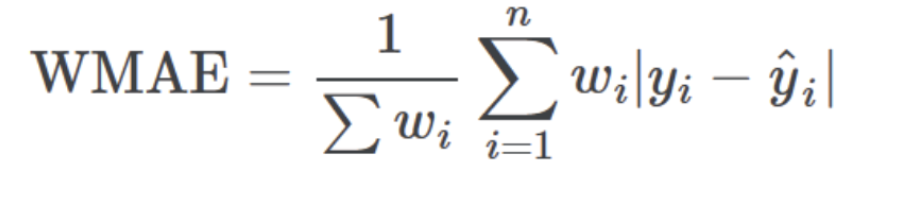

# 2 | **Data Understanding**
### **Import Library**

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import inflection

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import ensemble, model_selection, metrics

import warnings
warnings.filterwarnings('ignore')


### **Data Preparation**

![截屏2024-04-02 08.59.27.png](<attachment:截屏2024-04-02 08.59.27.png>)
![截屏2024-04-02 09.00.14.png](<attachment:截屏2024-04-02 09.00.14.png>)
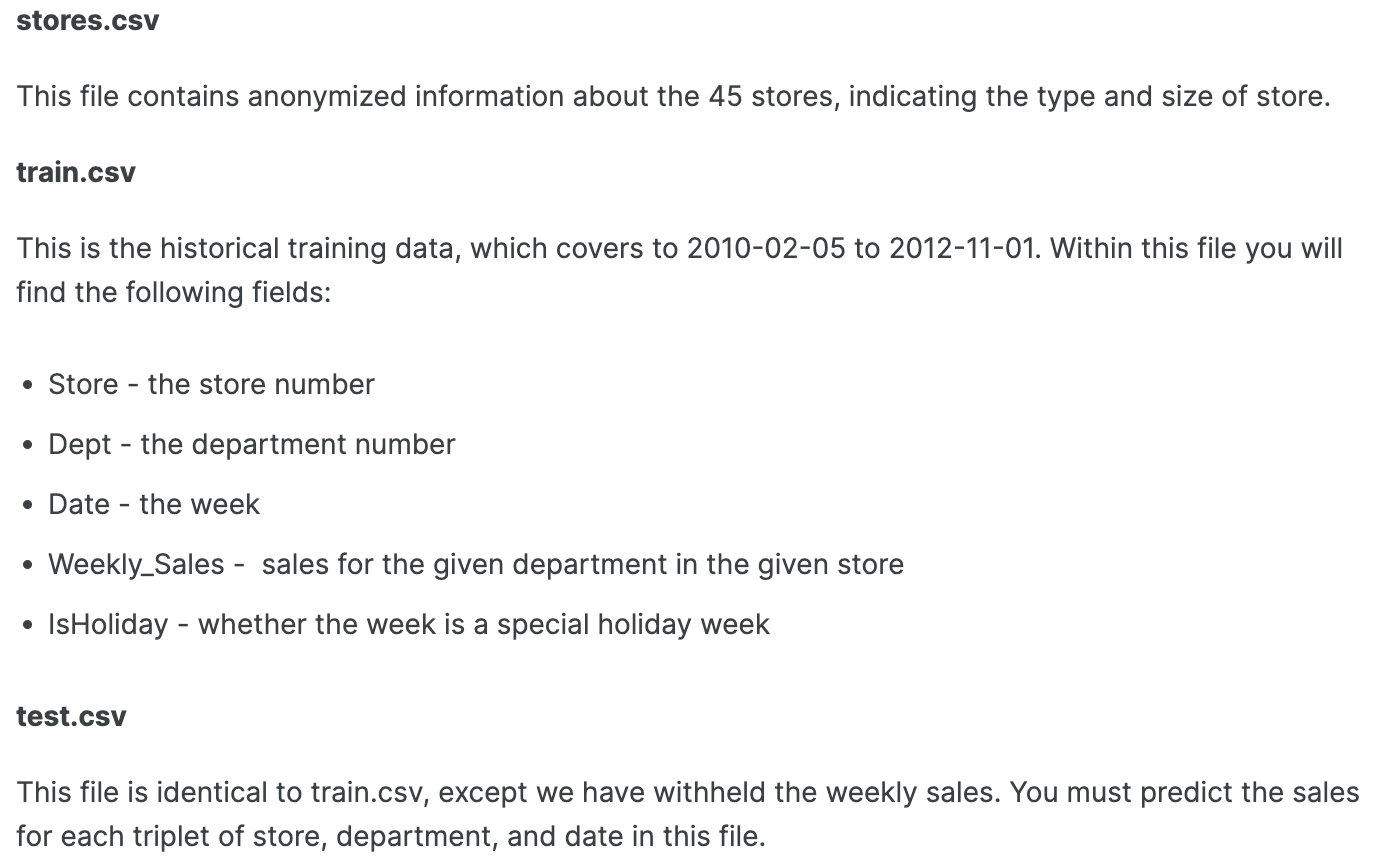
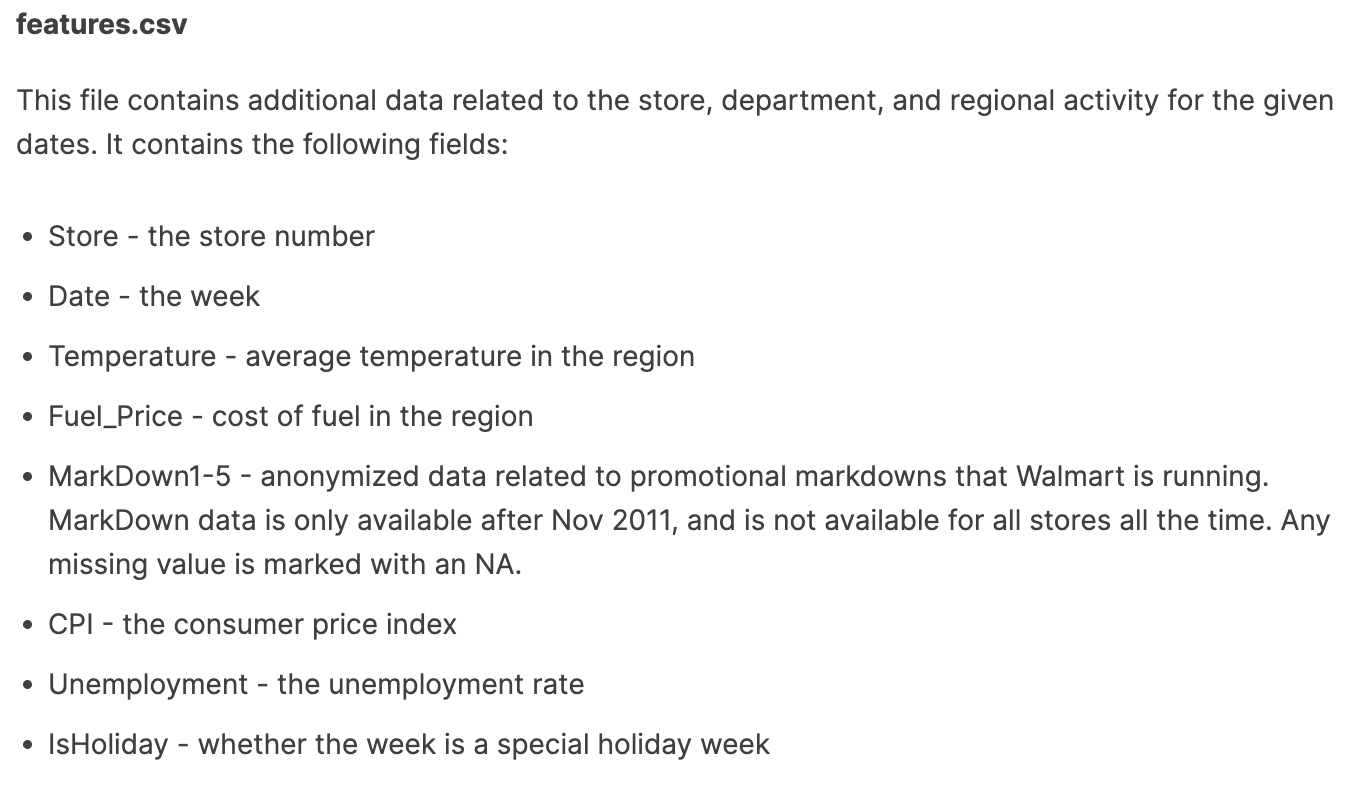

In [46]:
def read_data(name, link):
    data = pd.read_csv(link)
    print(f"Data Name: {name}")
    print(data.head(5))
    return data

train = read_data("train", "/Users/theresa/Desktop/课件/新代码/train.csv")
test = read_data("test", "/Users/theresa/Desktop/课件/新代码/test.csv")
store = read_data("store", "/Users/theresa/Desktop/课件/新代码/stores.csv")
feature = read_data("feature", "/Users/theresa/Desktop/课件/新代码/features.csv")


Data Name: train
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
Data Name: test
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
Data Name: store
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875
Data Name: feature
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514 

In [47]:
def check_missing_values(df, df_name):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing_percentage = (missing / len(df)) * 100
    missing_val = pd.DataFrame({'NaN_count': missing, 'NaN_percentage': missing_percentage})
    missing_val = missing_val.sort_values(by='NaN_percentage', ascending=False)
    print(f"Missing Values in DataFrame '{df_name}':")
    print(missing_val)
    print(" ")
    return missing_val


In [48]:
check_missing_values(train,"train")
check_missing_values(test,"test")
check_missing_values(store,"store")
check_missing_values(feature,"feature")

Missing Values in DataFrame 'train':
Empty DataFrame
Columns: [NaN_count, NaN_percentage]
Index: []
 
Missing Values in DataFrame 'test':
Empty DataFrame
Columns: [NaN_count, NaN_percentage]
Index: []
 
Missing Values in DataFrame 'store':
Empty DataFrame
Columns: [NaN_count, NaN_percentage]
Index: []
 
Missing Values in DataFrame 'feature':
              NaN_count  NaN_percentage
MarkDown2          5269       64.334554
MarkDown4          4726       57.704518
MarkDown3          4577       55.885226
MarkDown1          4158       50.769231
MarkDown5          4140       50.549451
CPI                 585        7.142857
Unemployment        585        7.142857
 


NaN_count  NaN_percentage
MarkDown2          5269       64.334554
MarkDown4          4726       57.704518
MarkDown3          4577       55.885226
MarkDown1          4158       50.769231
MarkDown5          4140       50.549451
CPI                 585        7.142857
Unemployment        585        7.142857

In [49]:
feature['CPI'].fillna(feature['CPI'].median(), inplace=True)
feature['Unemployment'].fillna(feature['Unemployment'].median(), inplace=True)

col_fillwna = ['MarkDown2','MarkDown4','MarkDown3','MarkDown1','MarkDown5']
feature[col_fillwna] = feature[col_fillwna].fillna(0)
check_missing_values(feature,"feature")

Missing Values in DataFrame 'feature':
Empty DataFrame
Columns: [NaN_count, NaN_percentage]
Index: []
 


Empty DataFrame
Columns: [NaN_count, NaN_percentage]
Index: []

In [50]:
data = train.merge(feature, on=['Store', 'Date', 'IsHoliday'], how='inner')
data = data.merge(store, on='Store', how='inner')
data.head(5)


test = test.merge(feature, on=['Store', 'Date', 'IsHoliday'], how='inner')
test = test.merge(store, on='Store', how='inner')
test.head(5)

Store  Dept        Date  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
0      1     1  2012-11-02      False        55.32       3.386    6766.44   
1      1     2  2012-11-02      False        55.32       3.386    6766.44   
2      1     3  2012-11-02      False        55.32       3.386    6766.44   
3      1     4  2012-11-02      False        55.32       3.386    6766.44   
4      1     5  2012-11-02      False        55.32       3.386    6766.44   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type  \
0     5147.7      50.82     3639.9    2737.42  223.462779         6.573    A   
1     5147.7      50.82     3639.9    2737.42  223.462779         6.573    A   
2     5147.7      50.82     3639.9    2737.42  223.462779         6.573    A   
3     5147.7      50.82     3639.9    2737.42  223.462779         6.573    A   
4     5147.7      50.82     3639.9    2737.42  223.462779         6.573    A   

     Size  
0  151315  
1  151315  
2  151315  
3  151315  
4  151315

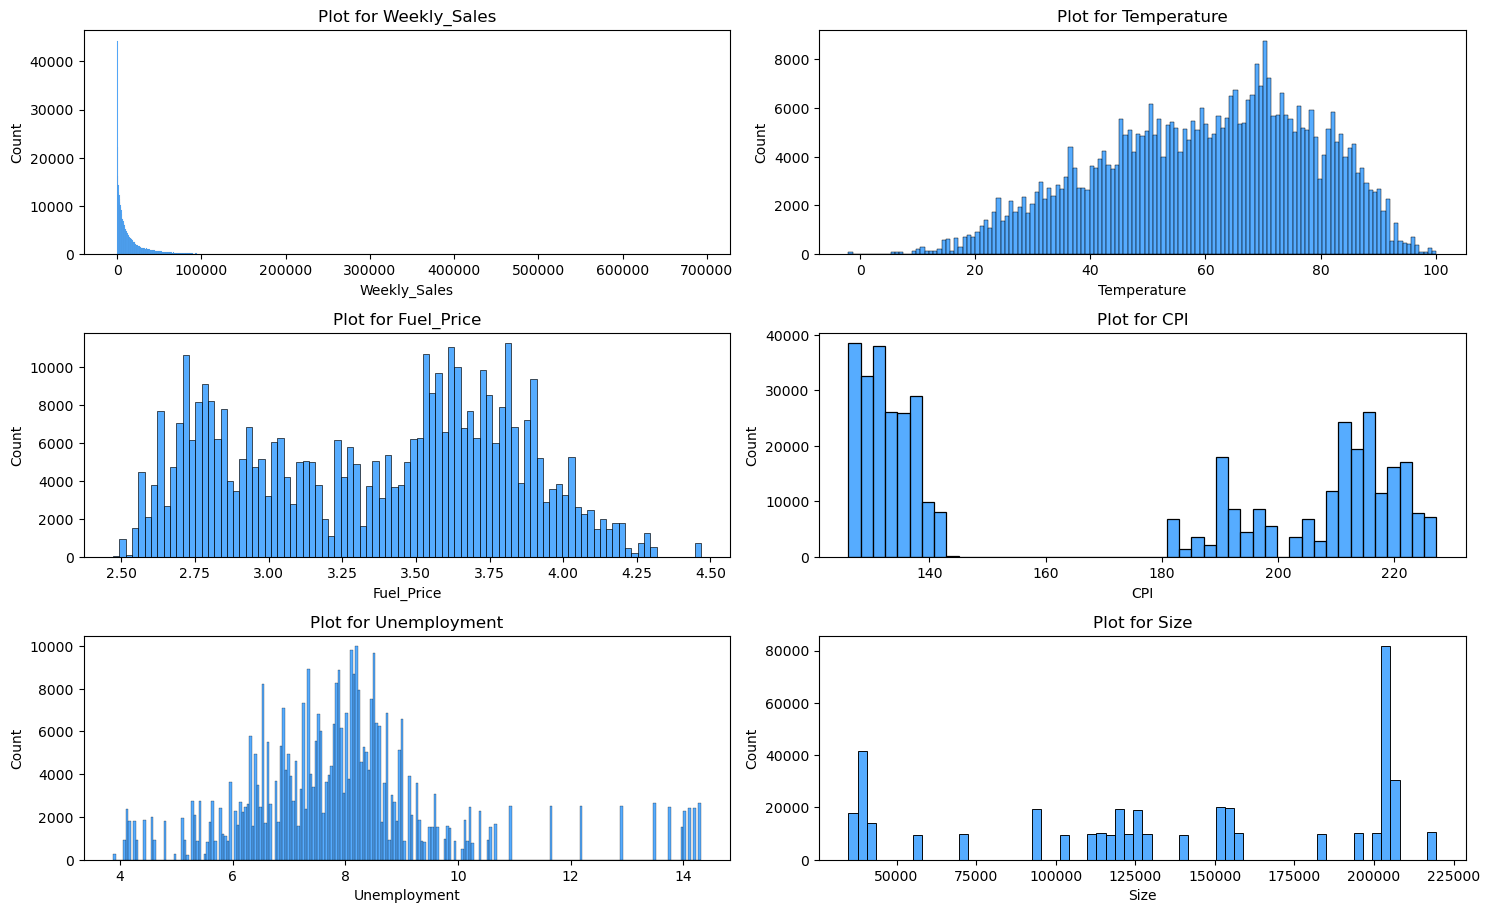

In [51]:
#Visualized the data to know the distribution from numerical features
exclude = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Store', 'Dept']
num_data = [col for col in data.select_dtypes(include='number').columns if col not in exclude]

count = 0 
fig = plt.figure(figsize=(15,30))
for feature in num_data:
    count += 1
    ax = plt.subplot(10,2, count)
    sns.histplot(data=data, x=feature, color='dodgerblue')
    plt.title(f'Plot for {feature}')
    fig.tight_layout()
plt.show()

![截屏2024-04-01 23.54.33.png](<attachment:截屏2024-04-01 23.54.33.png>)
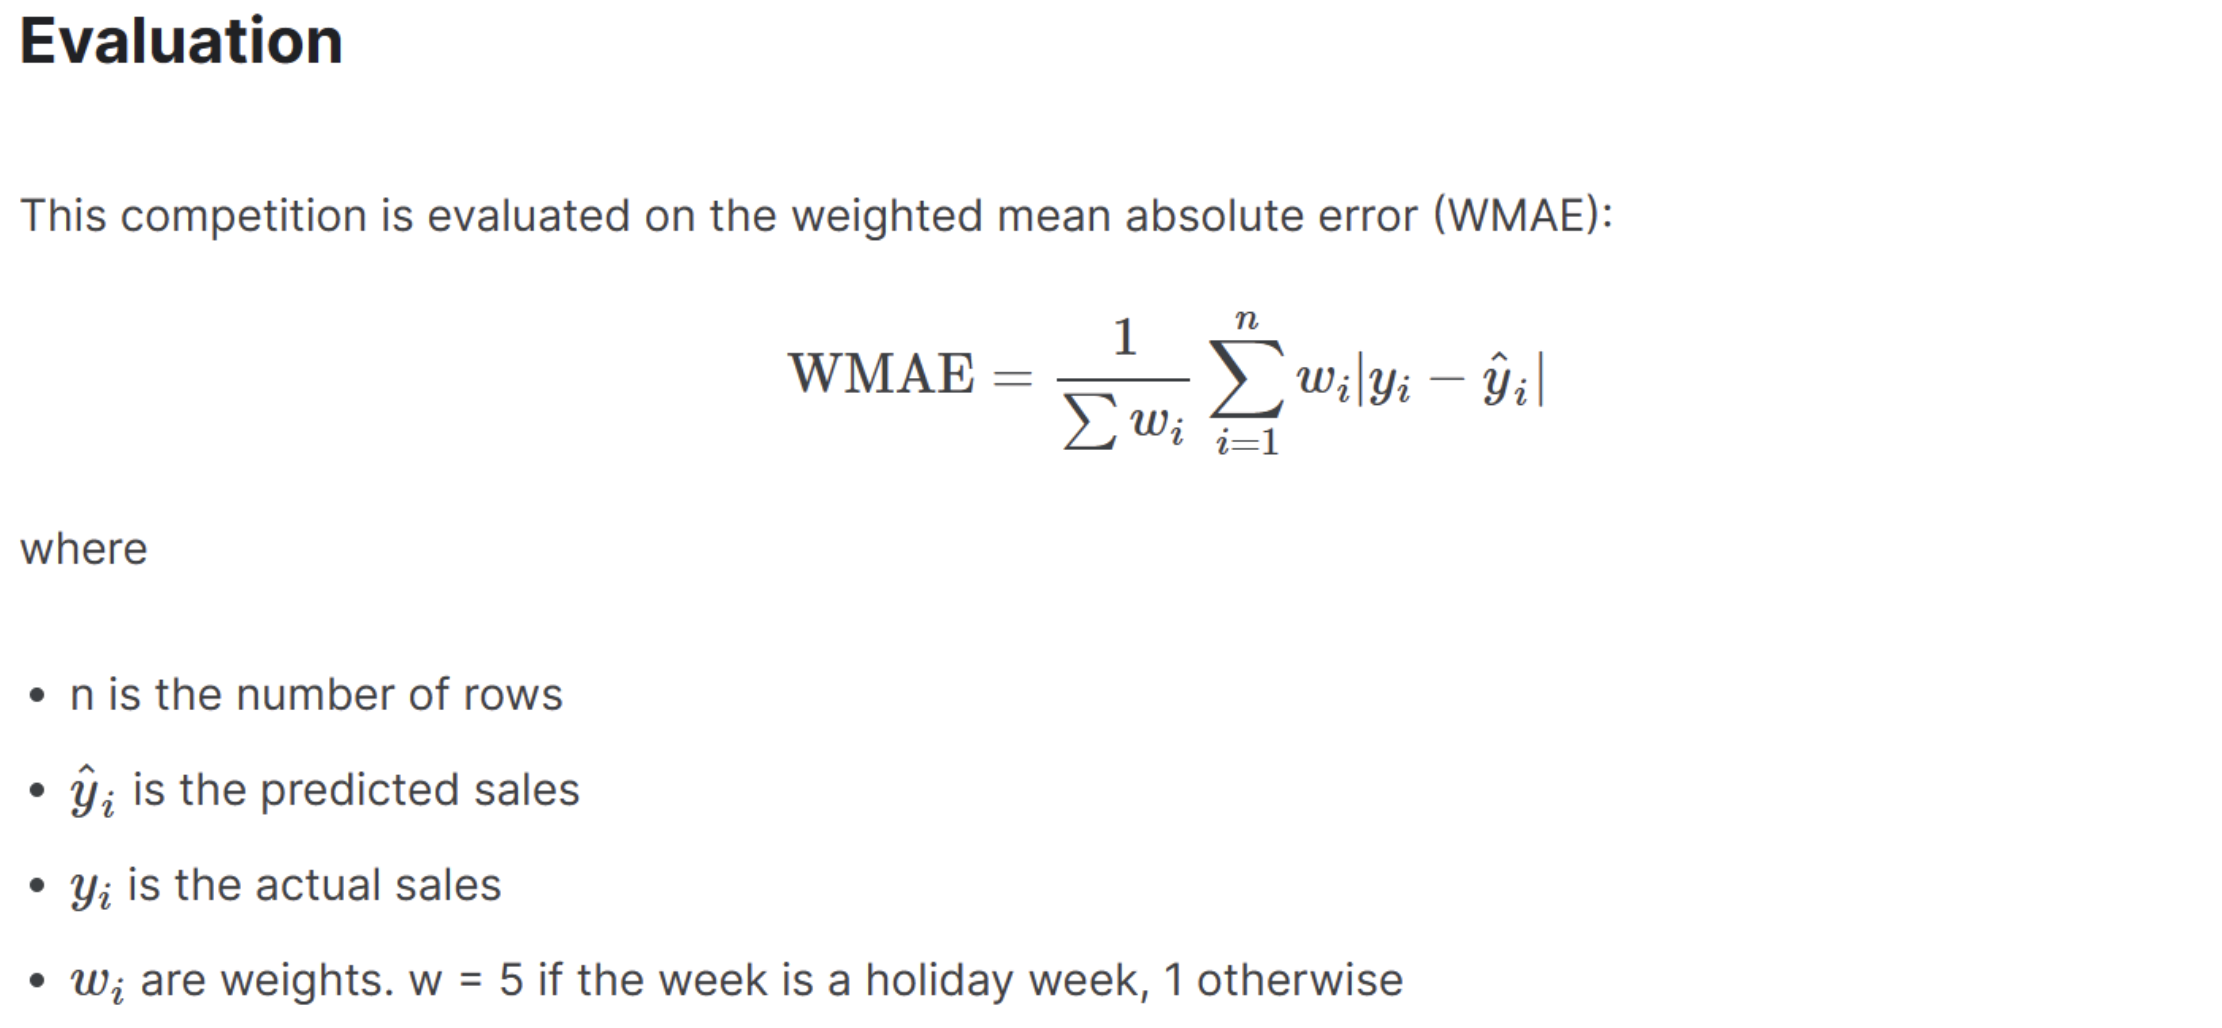

In [52]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week
data['Day'] = data['Date'].dt.day

test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].dt.isocalendar().week
test['Day'] = test['Date'].dt.day

In [53]:
unique_attribute = []

for col in data.columns:
    unique_attribute.append([col,data[col].unique(),data[col].nunique()])

unique_attribute = pd.DataFrame(data=unique_attribute, columns = ['column','unique_value','total'])
unique_attribute

column                                       unique_value   total
0          Store  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...      45
1           Dept  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...      81
2           Date  [2010-02-05T00:00:00.000000000, 2010-02-12T00:...     143
3   Weekly_Sales  [24924.5, 50605.27, 13740.12, 39954.04, 32229....  359464
4      IsHoliday                                      [False, True]       2
5    Temperature  [42.31, 38.51, 39.93, 46.63, 46.5, 57.79, 54.5...    3528
6     Fuel_Price  [2.572, 2.548, 2.514, 2.561, 2.625, 2.667, 2.7...     892
7      MarkDown1  [0.0, 10382.9, 6074.12, 410.31, 5629.51, 4640....    2278
8      MarkDown2  [0.0, 6115.67, 254.39, 98.0, 68.0, 19.0, 67.0,...    1499
9      MarkDown3  [0.0, 215.07, 51.98, 55805.51, 1398.11, 105.02...    1662
10     MarkDown4  [0.0, 2406.62, 427.39, 8.0, 2084.64, 3639.42, ...    1945
11     MarkDown5  [0.0, 6551.42, 5988.57, 554.92, 20475.32, 1446...    2294
12           CPI  [211.0963582, 211.2421698, 211.2891429, 211.31...    2145
13  Unemployment  [8.106, 7.808, 7.787, 7.838, 7.742, 7.682, 7.9...     349
14          Type                                          [A, B, C]       3
15          Size  [151315, 202307, 37392, 205863, 34875, 202505,...      40
16          Year                                 [2010, 2011, 2012]       3
17         Month            [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1]      12
18          Week  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...      52
19           Day  [5, 12, 19, 26, 2, 9, 16, 23, 30, 7, 14, 21, 2...      31

# 3 | **Data Visualization**
### **Exploratory Data Analysis (EDA)**

In [54]:
data.shape

(421570, 20)

In [15]:
data.describe()

Store           Dept   Weekly_Sales    Temperature  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546      44.260317   15981.258123      60.090059   
std        12.785297      30.492054   22711.183519      18.447931   
min         1.000000       1.000000   -4988.940000      -2.060000   
25%        11.000000      18.000000    2079.650000      46.680000   
50%        22.000000      37.000000    7612.030000      62.090000   
75%        33.000000      74.000000   20205.852500      74.280000   
max        45.000000      99.000000  693099.360000     100.140000   

          Fuel_Price      MarkDown1      MarkDown2      MarkDown3  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean        3.361027    2590.074819     879.974298     468.087665   
std         0.458515    6052.385934    5084.538801    5528.873453   
min         2.472000       0.000000    -265.760000     -29.100000   
25%         2.933000       0.000000       0.000000       0.000000   
50%         3.452000       0.000000       0.000000       0.000000   
75%         3.738000    2809.050000       2.200000       4.540000   
max         4.468000   88646.760000  104519.540000  141630.610000   

           MarkDown4      MarkDown5            CPI   Unemployment  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean     1083.132268    1662.772385     171.201947       7.960289   
std      3894.529945    4207.629321      39.159276       1.863296   
min         0.000000       0.000000     126.064000       3.879000   
25%         0.000000       0.000000     132.022667       6.891000   
50%         0.000000       0.000000     182.318780       7.866000   
75%       425.290000    2168.040000     212.416993       8.572000   
max     67474.850000  108519.280000     227.232807      14.313000   

                Size           Year          Month       Week            Day  
count  421570.000000  421570.000000  421570.000000   421570.0  421570.000000  
mean   136727.915739    2010.968591       6.449510  25.826762      15.673131  
std     60980.583328       0.796876       3.243217  14.151887       8.753549  
min     34875.000000    2010.000000       1.000000        1.0       1.000000  
25%     93638.000000    2010.000000       4.000000       14.0       8.000000  
50%    140167.000000    2011.000000       6.000000       26.0      16.000000  
75%    202505.000000    2012.000000       9.000000       38.0      23.000000  
max    219622.000000    2012.000000      12.000000       52.0      31.000000

In [16]:
data = data[data['Weekly_Sales']>0]
data

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  \
0           1     1 2010-02-05      24924.50      False        42.31   
1           1     2 2010-02-05      50605.27      False        42.31   
2           1     3 2010-02-05      13740.12      False        42.31   
3           1     4 2010-02-05      39954.04      False        42.31   
4           1     5 2010-02-05      32229.38      False        42.31   
...       ...   ...        ...           ...        ...          ...   
421565     45    93 2012-10-26       2487.80      False        58.85   
421566     45    94 2012-10-26       5203.31      False        58.85   
421567     45    95 2012-10-26      56017.47      False        58.85   
421568     45    97 2012-10-26       6817.48      False        58.85   
421569     45    98 2012-10-26       1076.80      False        58.85   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0            2.572       0.00       0.00        0.0       0.00       0.00   
1            2.572       0.00       0.00        0.0       0.00       0.00   
2            2.572       0.00       0.00        0.0       0.00       0.00   
3            2.572       0.00       0.00        0.0       0.00       0.00   
4            2.572       0.00       0.00        0.0       0.00       0.00   
...            ...        ...        ...        ...        ...        ...   
421565       3.882    4018.91      58.08      100.0     211.94     858.33   
421566       3.882    4018.91      58.08      100.0     211.94     858.33   
421567       3.882    4018.91      58.08      100.0     211.94     858.33   
421568       3.882    4018.91      58.08      100.0     211.94     858.33   
421569       3.882    4018.91      58.08      100.0     211.94     858.33   

               CPI  Unemployment Type    Size  Year  Month  Week  Day  
0       211.096358         8.106    A  151315  2010      2     5    5  
1       211.096358         8.106    A  151315  2010      2     5    5  
2       211.096358         8.106    A  151315  2010      2     5    5  
3       211.096358         8.106    A  151315  2010      2     5    5  
4       211.096358         8.106    A  151315  2010      2     5    5  
...            ...           ...  ...     ...   ...    ...   ...  ...  
421565  192.308899         8.667    B  118221  2012     10    43   26  
421566  192.308899         8.667    B  118221  2012     10    43   26  
421567  192.308899         8.667    B  118221  2012     10    43   26  
421568  192.308899         8.667    B  118221  2012     10    43   26  
421569  192.308899         8.667    B  118221  2012     10    43   26  

[420212 rows x 20 columns]

**Sales vs Time**

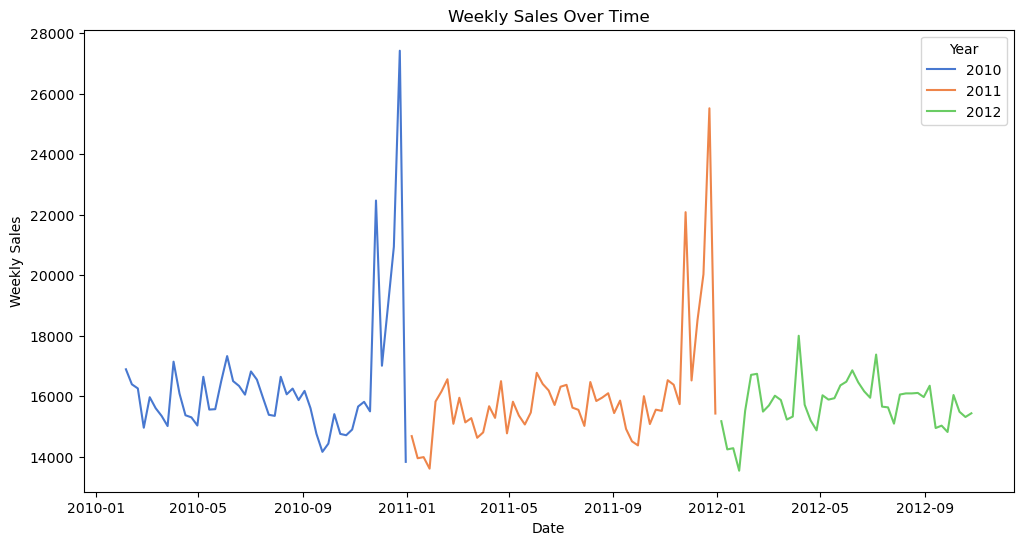

In [17]:
#Weekly sales over time linechart
custom_palette = sns.color_palette("muted", n_colors=len(data['Year'].unique()))
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='Date', y='Weekly_Sales', ci=None, hue='Year', palette=custom_palette)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.show()

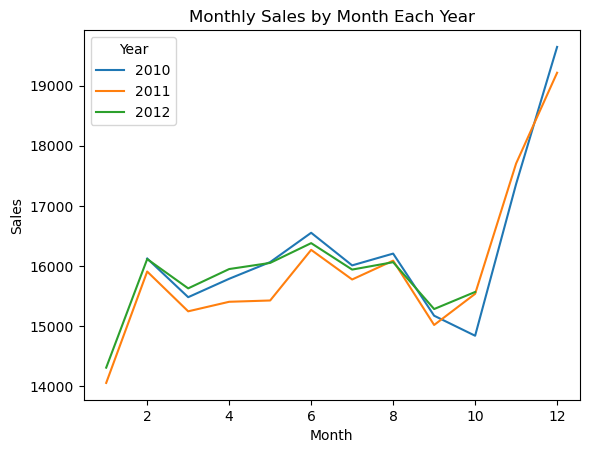

In [18]:
monthly_sales = pd.pivot_table(data, values='Weekly_Sales', columns='Year', index='Month')
monthly_sales.plot(title='Monthly Sales by Month Each Year', ylabel='Sales', xlabel='Month')
plt.legend(title='Year')
plt.show()

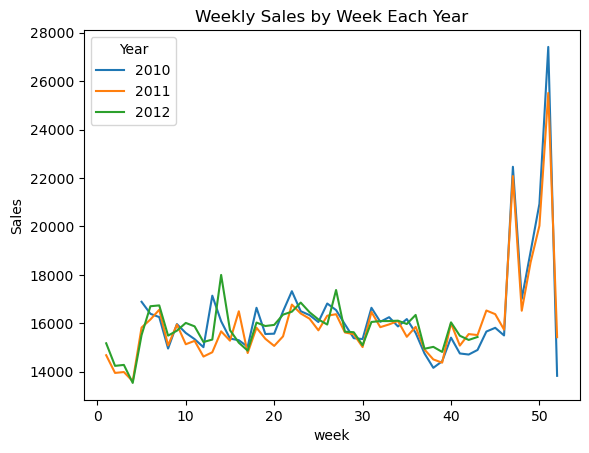

In [19]:
#Weekly sales linechart each year
weekly_sales = pd.pivot_table(data, values='Weekly_Sales', columns='Year', index='Week')
weekly_sales.plot(title='Weekly Sales by Week Each Year', ylabel='Sales', xlabel='week')
plt.legend(title='Year')
plt.show()

We noticed a seasonal factor evident in the data, indicating a recurring pattern across each year. This factor leads to a significant increase in sales, particularly during November and December which around week 47 and week 51, coinciding with the holiday period including Thanksgiving and Christmas.

**Sales VS Holiday Effect**

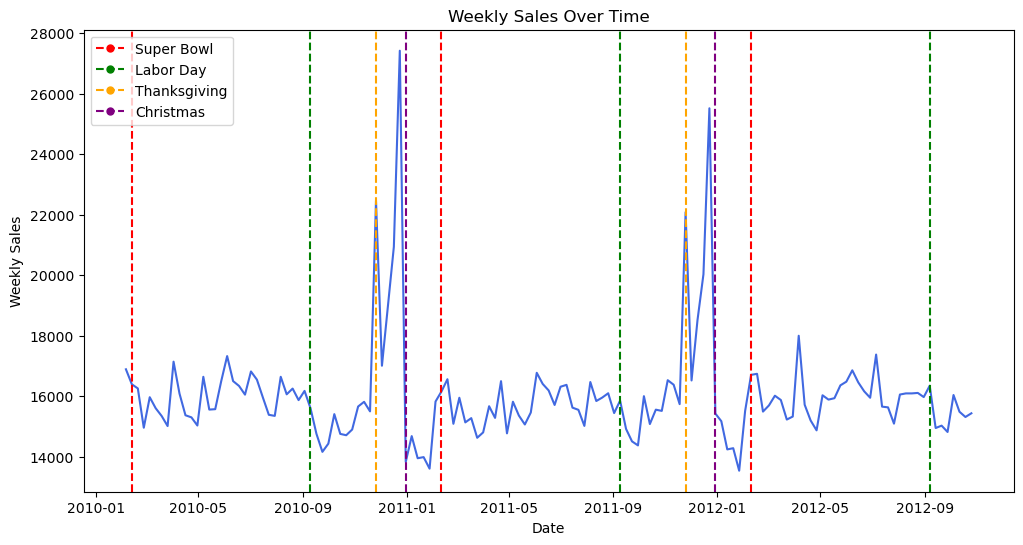

In [20]:
events = {
    'Super Bowl': {
        'dates': ['2010-02-12', '2011-02-11', '2012-02-10'],
        'color': 'red'
    },
    'Labor Day': {
        'dates': ['2010-09-10', '2011-09-09', '2012-09-07'],
        'color': 'green'
    },
    'Thanksgiving': {
        'dates': ['2010-11-26', '2011-11-25'],
        'color': 'orange'
    },
    'Christmas': {
        'dates': ['2010-12-31', '2011-12-30'],
        'color': 'purple'
    }
}

data['Date'] = pd.to_datetime(data['Date'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Weekly_Sales', ci=None, color='royalblue', label='Weekly Sales')

for event, info in events.items():
    for date in info['dates']:
        plt.axvline(x=pd.to_datetime(date), linestyle='--', color=info['color'])

legend_labels = [plt.Line2D([0], [0], color=info['color'], linestyle='--', marker='o', markersize=5, label=event) for event, info in events.items()]
plt.legend(handles=legend_labels, loc='upper left')

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.show()


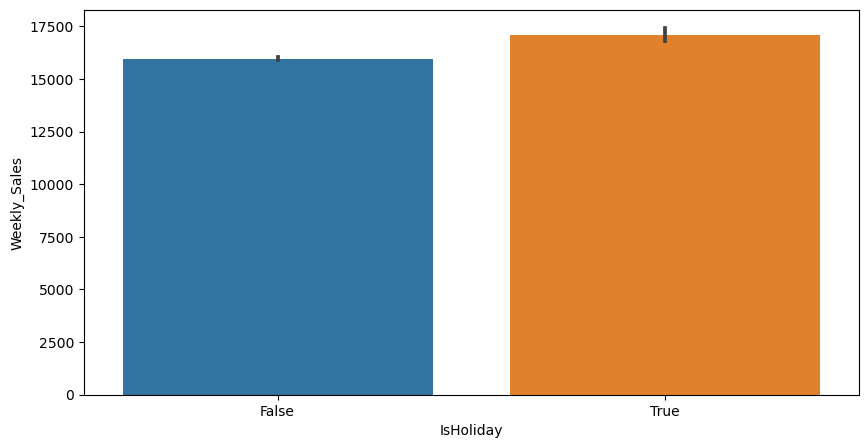

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=data)
plt.show()


In [22]:
# Super Bowl
data.loc[(data['Date']=='2010-02-12')|(data['Date']=='2011-02-11')|(data['Date']=='2012-02-10'), 'super_bowl'] = 1
data.loc[(data['Date']!='2010-02-12')&(data['Date']!='2011-02-11')&(data['Date']!='2012-02-10'), 'super_bowl'] = 0

# Labor Day
data.loc[(data['Date']=='2010-09-10')|(data['Date']=='2011-09-09')|(data['Date']=='2012-09-07'), 'labor_day'] = 1
data.loc[(data['Date']!='2010-09-10')&(data['Date']!='2011-09-09')&(data['Date']!='2012-09-07'), 'labor_day'] = 0

# Thanksgiving
data.loc[(data['Date']=='2010-11-26')|(data['Date']=='2011-11-25'), 'thanksgiving'] = 1
data.loc[(data['Date']!='2010-11-26')&(data['Date']!='2011-11-25'), 'thanksgiving'] = 0

# Christmas
data.loc[(data['Date']=='2010-12-31')|(data['Date']=='2011-12-30'), 'christmas'] = 1
data.loc[(data['Date']!='2010-12-31')&(data['Date']!='2011-12-30'), 'christmas'] = 0


In [23]:
def holiday_barplot(data, holidays):
    fig, axes = plt.subplots(1, len(holidays), figsize=(15, 5))
    for i, holiday_name in enumerate(holidays):
        sns.barplot(x=holiday_name, y='Weekly_Sales', data=data, ax=axes[i])
        axes[i].set_title(holiday_name)
    
    plt.tight_layout()
    plt.show()

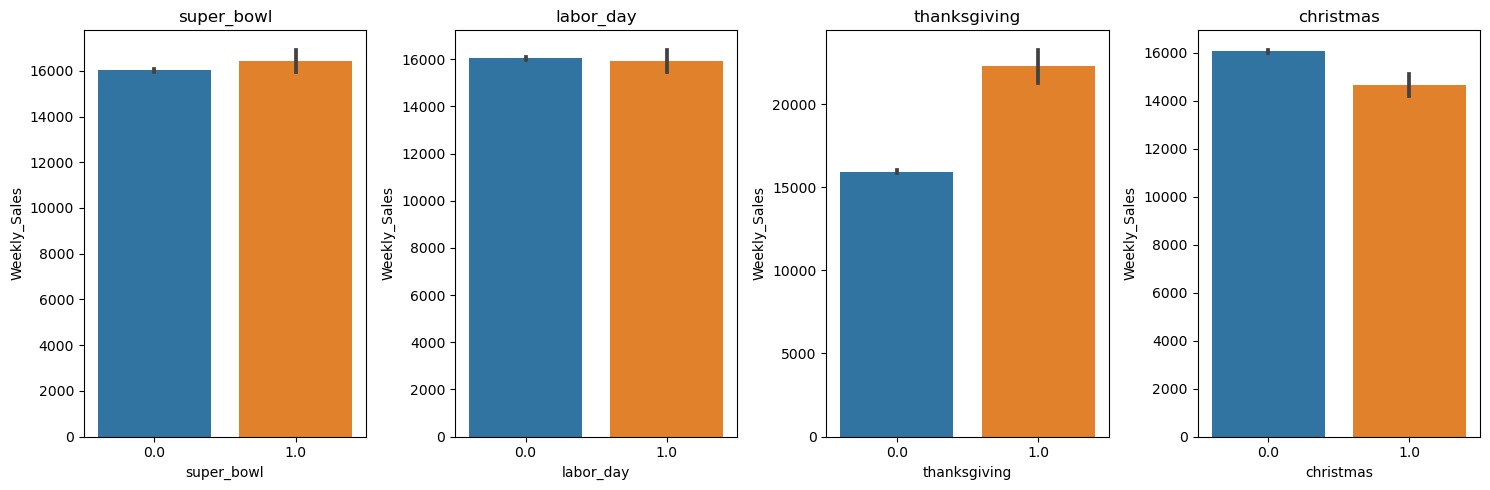

In [24]:
holidays = ['super_bowl', 'labor_day', 'thanksgiving', 'christmas']
holiday_barplot(data, holidays)

The holiday effect significantly boosts weekly sales, and Thanksgiving period saw the highest weekly average sales when compared to other holidays.

**Sales VS Markdown**

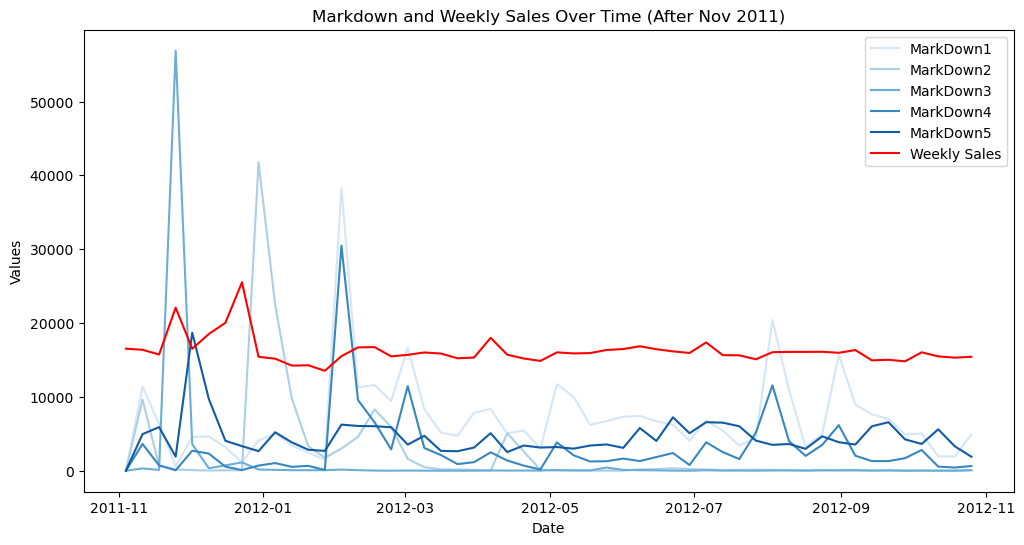

In [25]:
data['Date'] = pd.to_datetime(data['Date'])
data_after_nov_2011 = data[data['Date'] >= '2011-11-01']
plt.figure(figsize=(12, 6))
blue_palette = sns.color_palette("Blues", 5)
legend_names = {f'MarkDown{i}': f'MarkDown{i}' for i in range(1, 6)}
legend_names['Weekly_Sales'] = 'Weekly Sales'
for i in range(1, 6):
    sns.lineplot(data=data_after_nov_2011, x='Date', y=f'MarkDown{i}', ci=None, 
                 label=legend_names[f'MarkDown{i}'], color=blue_palette[i-1])
sns.lineplot(data=data_after_nov_2011, x='Date', y='Weekly_Sales', ci=None, 
             label=legend_names['Weekly_Sales'], color='red')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Markdown and Weekly Sales Over Time (After Nov 2011)')
plt.legend()
plt.show()


Markdown plays a significant role in boosting sales.

**Sales vs Department and Store**

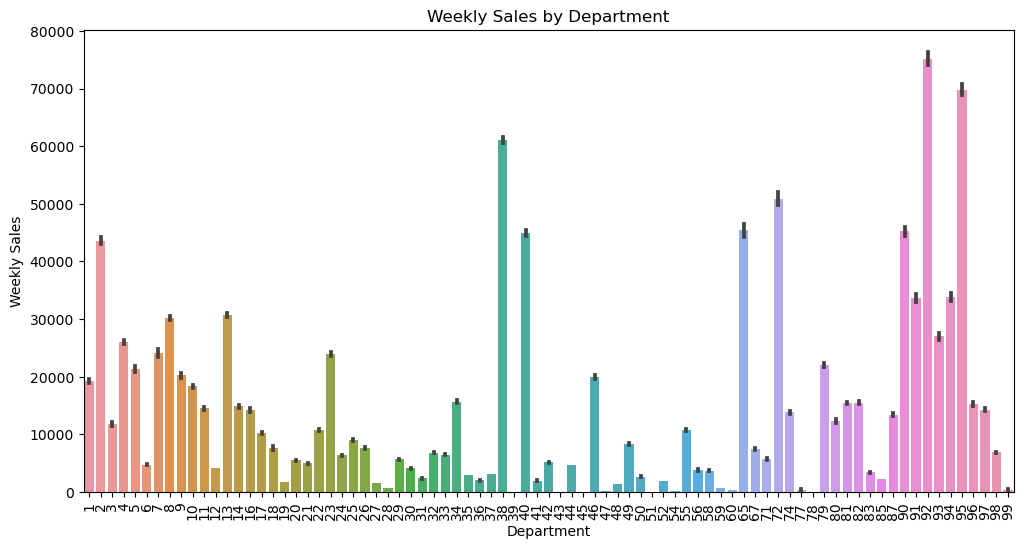

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Dept', y='Weekly_Sales')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=90)
plt.title('Weekly Sales by Department')
plt.show()

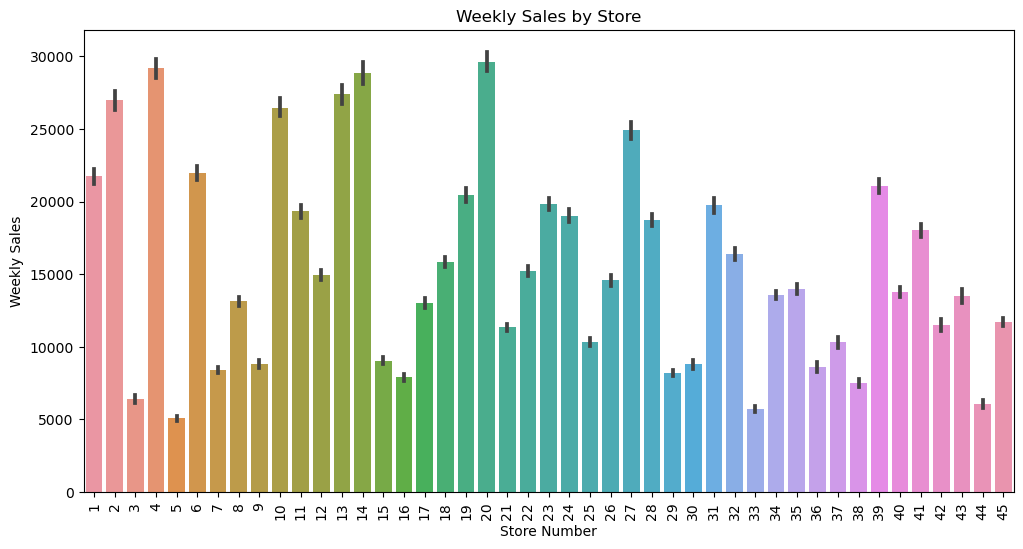

In [27]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Store', y='Weekly_Sales')
plt.xlabel('Store Number')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=90)
plt.title('Weekly Sales by Store')
plt.show()

**Store Type Analysis**

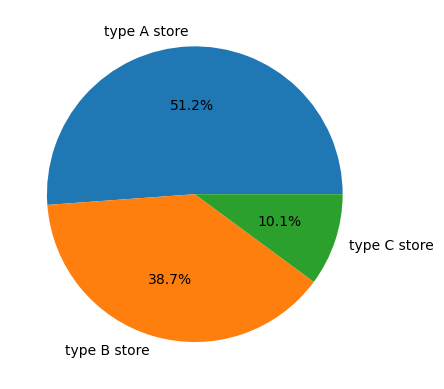

In [28]:
storetype_count = data['Type'].value_counts()
store_index = storetype_count.index.tolist()
labels_name = {'A':'type A store', 'B':'type B store', 'C':'type C store'}
labels = [labels_name.get(x, '') for x in store_index]
plt.pie(storetype_count, labels=labels, autopct='%1.1f%%')
plt.show()

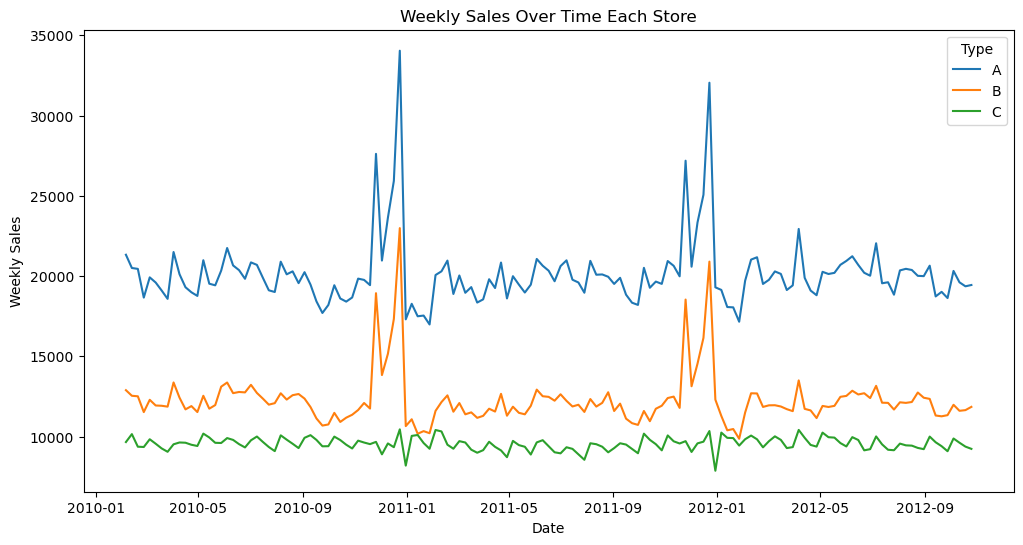

In [29]:
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='Date', y='Weekly_Sales', hue='Type', ci=None)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time Each Store')
plt.show()

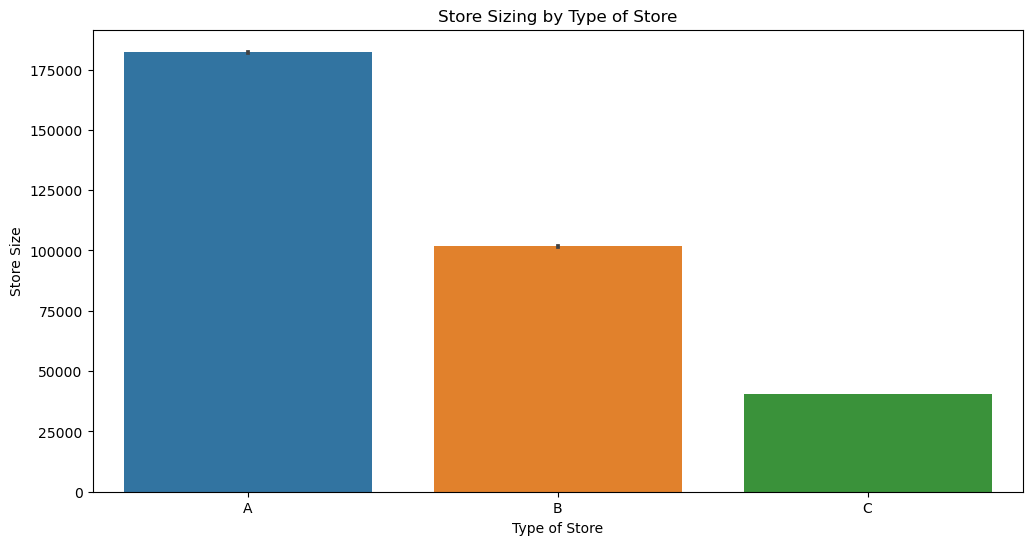

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Type', y='Size')
plt.xlabel('Type of Store')
plt.ylabel('Store Size')
plt.title('Store Sizing by Type of Store')
plt.show()

**Fuel Price, Temperature, CPI, and Unemployment vs Over Time**

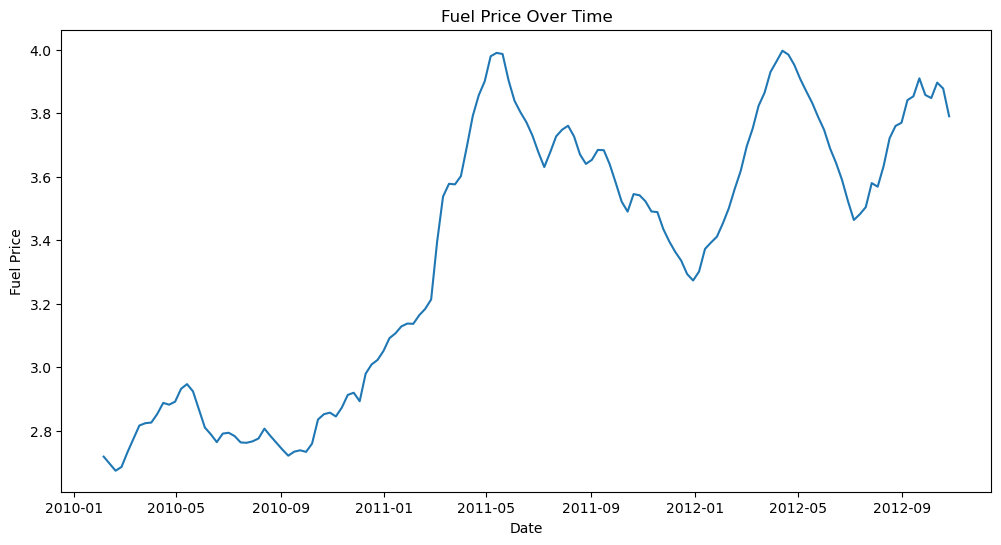

In [31]:
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='Date', y='Fuel_Price', ci=None)
plt.xlabel('Date')
plt.ylabel('Fuel Price')
plt.title('Fuel Price Over Time')
plt.show()

Date        
2010  315033   2010-07-16
2011  317680   2011-08-26
2012  319989   2012-08-10
Name: Date, dtype: datetime64[ns]


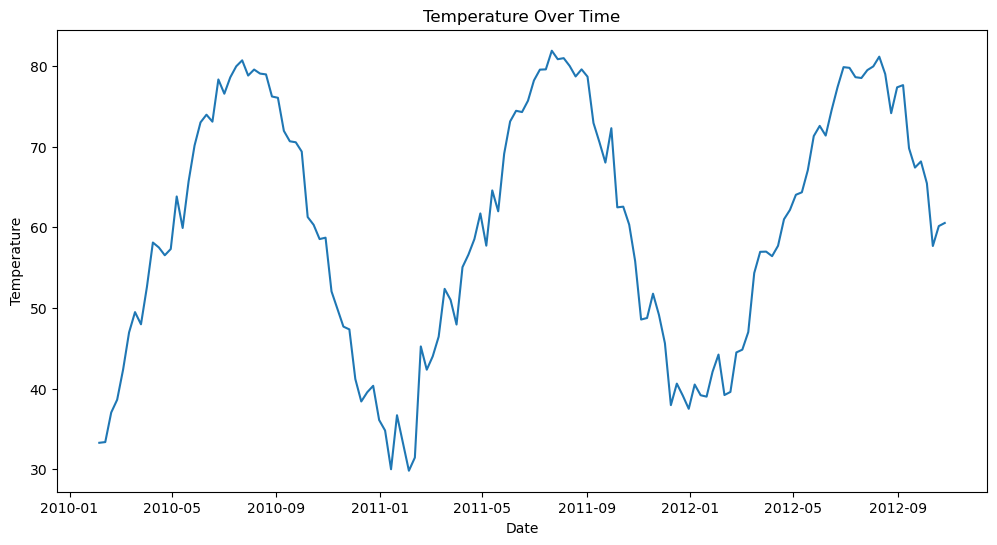

In [32]:
data = data.sort_values(by='Temperature', ascending=False)
top_temps = data.groupby(data['Date'].dt.year).apply(lambda x: x.nlargest(1, ['Temperature']))
print(top_temps['Date'])

plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='Date', y='Temperature', ci=None)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.show()

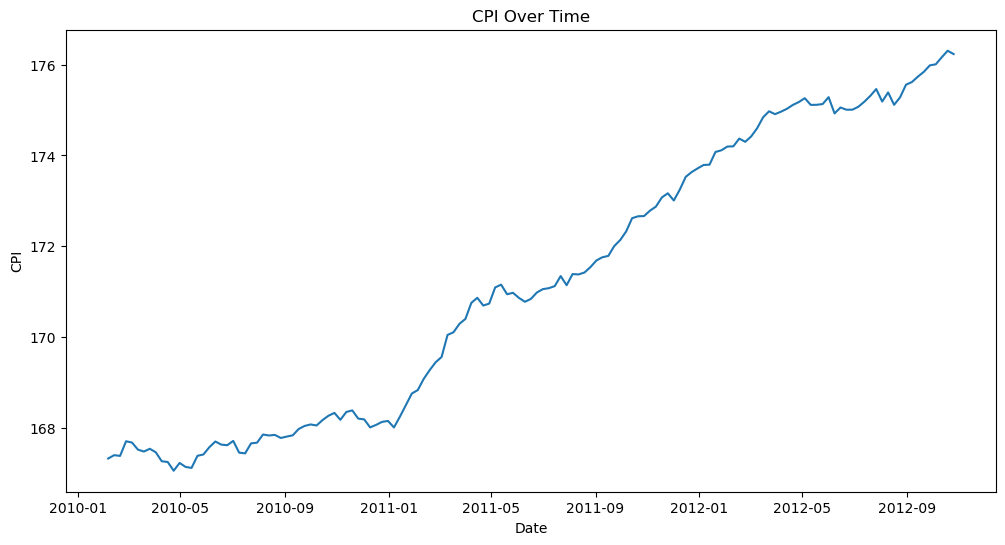

In [33]:
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='Date', y='CPI', ci=None)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI Over Time')
plt.show()

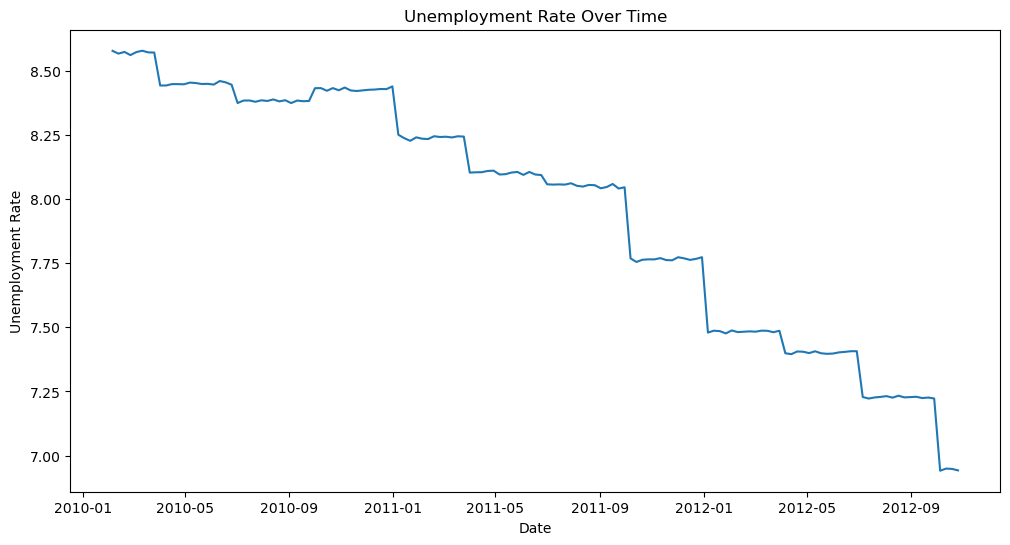

In [34]:
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='Date', y='Unemployment', ci=None)
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate Over Time')
plt.show()

There is no significant correlation between weekly sales and Fuel Price, CPI, Temperature and Unemployment

In [44]:
import plotly.graph_objects as go
import numpy as np
import plotly.figure_factory as ff
import pandas as pd

# Assuming you already have `train_df` DataFrame and `palletes` dictionary defined

# Calculate correlation matrix
corr = data.corr()

# Create a mask to hide upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Apply the mask to correlation matrix and round to two decimal places
df_mask = corr.mask(mask).round(2)

palletes = {
    'continuos': {
        'green_n_blues': [[0.0, 'rgb(0,68,27)'], [0.5, 'rgb(254,254,191)'], [1.0, 'rgb(8,29,88)']]
    }
}

template = go.layout.Template(
    layout=go.Layout(
        # Add your layout settings here
    )
)

# Create annotated heatmap
fig = ff.create_annotated_heatmap(
    z=df_mask.to_numpy(),  # Convert DataFrame to numpy array
    x=df_mask.columns.tolist(),
    y=df_mask.columns.tolist(),
    colorscale=palletes['continuos']['green_n_blues'],
    hoverinfo="none", 
    showscale=True, 
    ygap=1, 
    xgap=1
)

# Update x-axis to be at the bottom
fig.update_xaxes(side="bottom")

# Update layout
fig.update_layout(
    template=template,  # Assuming `template` is defined elsewhere
    width=900, 
    height=700,
    margin=dict(l=100),
    title={'text':'<b>Feature correlation (Heatmap)</b>', 'x': 0.075},
    title_x=0.5, 
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed'
)

# Remove 'nan' values from annotations
for i in range(len(fig.layout.annotations)):
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""

# Show the figure
fig.show()


#### Visualization findings conclusion:

The analysis of our data visualization highlights three main findings: 
- Firstly, there is a strong correlation between weekly sales and holidays, especially Thanksgiving and Christmas. 
- Secondly, markdown campaigns also exhibit a significant impact on weekly sales. 
- Thirdly, store size and department also play an important role in the weekly sales.

These insights emphasize the importance of considering holidays and markdown campaigns as crucial factors in our analysis. so we will use these findings to refine our feature engineering process, aiming to extract more valuable features. 

# 4 | Feature engineering

In [31]:
data_train = data.copy()
data_test = test.copy()

4.1 | Holidays
Since Thanksgiving and Christmas are the most importarnt holidays, I'm going to try some feature engineering on this features, and also Superbowl and Laborday.

In [32]:
data_train['Days_to_Thansksgiving'] = (pd.to_datetime(data_train["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(data_train["Date"], format="%Y-%m-%d")).dt.days.astype(int)
data_train['Days_to_Christmas'] = (pd.to_datetime(data_train["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(data_train["Date"], format="%Y-%m-%d")).dt.days.astype(int)

In [33]:
data_test['Days_to_Thansksgiving'] = (pd.to_datetime(data_test["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(data_test["Date"], format="%Y-%m-%d")).dt.days.astype(int)
data_test['Days_to_Christmas'] = (pd.to_datetime(data_test["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(data_test["Date"], format="%Y-%m-%d")).dt.days.astype(int)

In [34]:
data_train['SuperBowlWeek'] = data_train['Week'].apply(lambda x: 1 if x == 6 else 0)
data_train['LaborDay'] = data_train['Week'].apply(lambda x: 1 if x == 36 else 0)
data_train['Thanksgiving'] = data_train['Week'].apply(lambda x: 1 if x == 47 else 0)
data_train['Christmas'] = data_train['Week'].apply(lambda x: 1 if x == 52 else 0)

In [35]:
data_test['SuperBowlWeek'] = data_test['Week'].apply(lambda x: 1 if x == 6 else 0)
data_test['LaborDay'] = data_test['Week'].apply(lambda x: 1 if x == 36 else 0)
data_test['Thanksgiving'] = data_test['Week'].apply(lambda x: 1 if x == 47 else 0)
data_test['Christmas'] = data_test['Week'].apply(lambda x: 1 if x == 52 else 0)

# 5 | Encoding categorical data

In [36]:
data_train['IsHoliday'] = data_train['IsHoliday'].apply(lambda x: 1 if x == True else 0)
data_test['IsHoliday'] = data_test['IsHoliday'].apply(lambda x: 1 if x == True else 0)

In [37]:
data_train['Type'] = data_train['Type'].apply(lambda x: 1 if x == 'A' else (2 if x == 'B' else 3))
data_test['Type'] = data_test['Type'].apply(lambda x: 1 if x == 'A' else (2 if x == 'B' else 3))

# 6 | Machine Learning and Prediction Model

In [38]:
columns_to_drop = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'super_bowl', 'labor_day',
       'thanksgiving', 'christmas',]
data_train = data_train.drop(columns=columns_to_drop)

In [39]:
print(data_train)

        Store  Dept       Date  Weekly_Sales  IsHoliday  MarkDown1  MarkDown2  \
315033     33    46 2010-07-16       1855.12          0        0.0        0.0   
315042     33    82 2010-07-16       2504.58          0        0.0        0.0   
315034     33    52 2010-07-16          5.68          0        0.0        0.0   
315035     33    55 2010-07-16          9.00          0        0.0        0.0   
315036     33    60 2010-07-16         79.20          0        0.0        0.0   
...       ...   ...        ...           ...        ...        ...        ...   
62587       7    36 2011-02-04       1076.50          0        0.0        0.0   
62586       7    35 2011-02-04        383.01          0        0.0        0.0   
62585       7    34 2011-02-04       3135.35          0        0.0        0.0   
62584       7    33 2011-02-04       2270.27          0        0.0        0.0   
62573       7    22 2011-02-04       6268.83          0        0.0        0.0   

        MarkDown3  MarkDown

In [40]:
features = [feature for feature in data_train.columns if feature not in ('Date','Weekly_Sales')]
X = data_train[features].copy()
y = data_train.Weekly_Sales.copy()

In [41]:
data_sample = data_train.copy().sample(frac=.25)
X_sample = data_sample[features].copy()
y_sample = data_sample.Weekly_Sales.copy()
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_sample, y_sample, random_state=0, test_size=0.15)

In [43]:
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': xgb.XGBRegressor(random_state=0, objective='reg:squarederror'),
    'Random Forest': RandomForestRegressor(random_state=0),
    'LightGBM': lgb.LGBMRegressor(random_state=0)
}


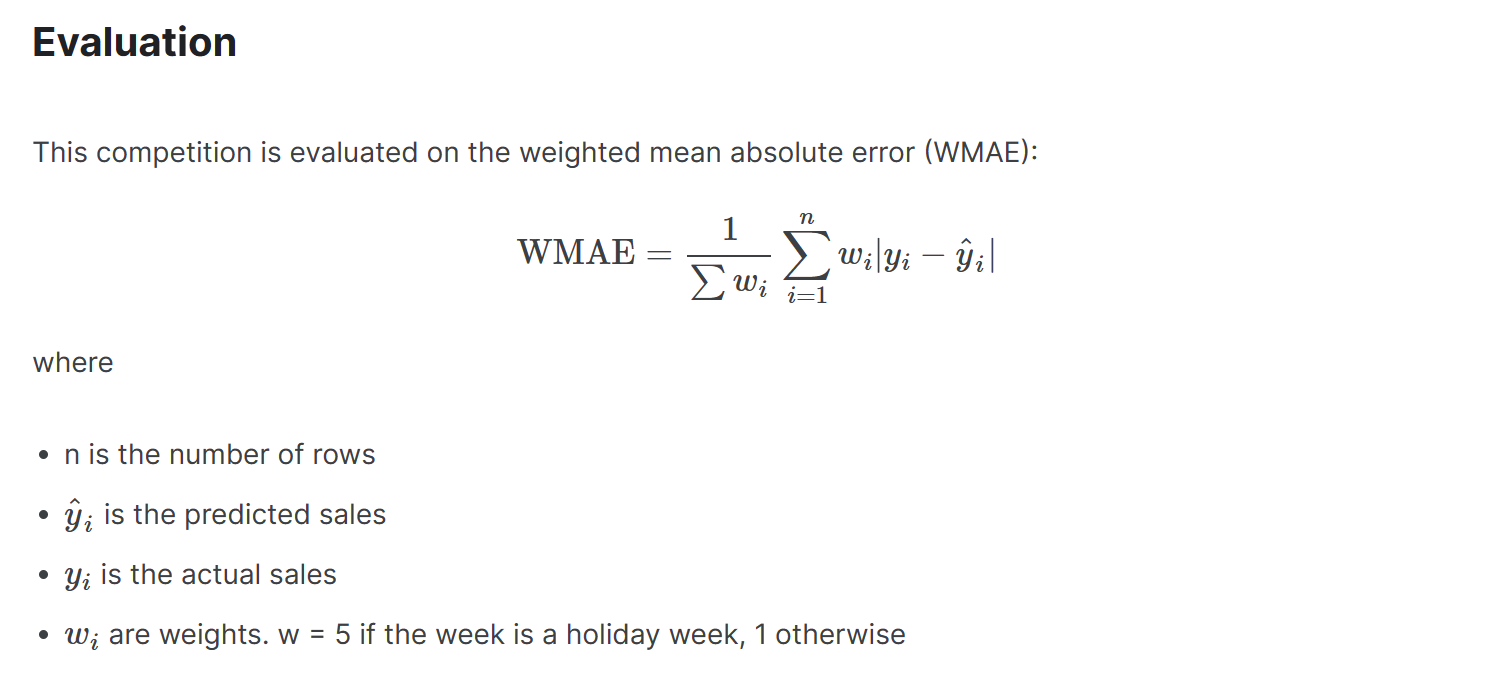

In [44]:
def WMAE(dataset, real, predicted):
    weights = dataset['IsHoliday'].apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights * abs(real - predicted)) / np.sum(weights), 2)

def model_evaluation(model, X_train, X_valid, y_train, y_valid):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_valid)
    wmae = WMAE(X_valid, y_valid, y_preds)
    return wmae

In [45]:
for name, model in models.items():
    wmae = model_evaluation(model, X_train, X_valid, y_train, y_valid)
    print(f'{name}: WMAE = {wmae}')

Linear Regression: WMAE = 15094.76
XGBoost: WMAE = 3356.26
Random Forest: WMAE = 2008.39
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1847
[LightGBM] [Info] Number of data points in the train set: 89295, number of used features: 20
[LightGBM] [Info] Start training from score 16108.863435
LightGBM: WMAE = 4503.71


In [46]:
n_estimators = [100, 150, 200]
max_depth = [10, 20, 30]
best_wmae_score = float('inf')  
best_params = {}


for i in n_estimators:
    for x in max_depth:
        RandomForestModel = RandomForestRegressor(n_estimators=i, max_depth=x, random_state=0)
        RandomForestModel.fit(X_train, y_train)
        y_preds = RandomForestModel.predict(X_valid)
        wmae_score = WMAE(X_valid, y_valid, y_preds)        
        print(f'WMAE for RandomForest: {wmae_score}, n_estimators: {i}, max_depth: {x}')
        if wmae_score < best_wmae_score:
            best_wmae_score = wmae_score
            best_params['n_estimators'] = i
            best_params['max_depth'] = x

print(f'Best WMAE score: {best_wmae_score}')
print(f'Best parameters: {best_params}')

WMAE for RandomForest: 4468.63, n_estimators: 100, max_depth: 10
WMAE for RandomForest: 2030.92, n_estimators: 100, max_depth: 20
WMAE for RandomForest: 2003.39, n_estimators: 100, max_depth: 30
WMAE for RandomForest: 4468.8, n_estimators: 150, max_depth: 10
WMAE for RandomForest: 2032.07, n_estimators: 150, max_depth: 20
WMAE for RandomForest: 2005.08, n_estimators: 150, max_depth: 30
WMAE for RandomForest: 4458.18, n_estimators: 200, max_depth: 10
WMAE for RandomForest: 2034.2, n_estimators: 200, max_depth: 20
WMAE for RandomForest: 2008.25, n_estimators: 200, max_depth: 30
Best WMAE score: 2003.39
Best parameters: {'n_estimators': 100, 'max_depth': 30}


In [47]:
RandomForest_fixmodel = RandomForestRegressor(
    n_estimators=best_params['n_estimators'], 
    max_depth=best_params['max_depth'], 
    random_state=0
)
RandomForest_fixmodel.fit(X_train, y_train)
train_score = RandomForest_fixmodel.score(X_train, y_train)
valid_score = RandomForest_fixmodel.score(X_valid, y_valid)
traindata_pred = RandomForest_fixmodel.predict(X_train)
rmse_score = np.sqrt(mean_squared_error(y_train, traindata_pred))
print(f'RandomForest Score with Optimal Parameters on Train Data: {train_score}')
print(f'RandomForest Score with Optimal Parameters on Validation Data: {valid_score}')
print(f'RMSE score for RandomForest with Optimal Parameters on Train Data: {rmse_score}')


RandomForest Score with Optimal Parameters on Train Data: 0.9951489795121052
RandomForest Score with Optimal Parameters on Validation Data: 0.9545428351812105
RMSE score for RandomForest with Optimal Parameters on Train Data: 1588.0625652322747


In [48]:
columns_to_drop = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
data_test= data_test.drop(columns=columns_to_drop)
print(data_test)

        Store  Dept       Date  IsHoliday  MarkDown1  MarkDown2  MarkDown3  \
0           1     1 2012-11-02          0    6766.44    5147.70      50.82   
1           1     2 2012-11-02          0    6766.44    5147.70      50.82   
2           1     3 2012-11-02          0    6766.44    5147.70      50.82   
3           1     4 2012-11-02          0    6766.44    5147.70      50.82   
4           1     5 2012-11-02          0    6766.44    5147.70      50.82   
...       ...   ...        ...        ...        ...        ...        ...   
115059     45    93 2013-07-26          0     212.02     851.73       2.06   
115060     45    94 2013-07-26          0     212.02     851.73       2.06   
115061     45    95 2013-07-26          0     212.02     851.73       2.06   
115062     45    97 2013-07-26          0     212.02     851.73       2.06   
115063     45    98 2013-07-26          0     212.02     851.73       2.06   

        MarkDown4  MarkDown5  Type  ...  Year  Month  Week  Day

In [49]:
features = [feature for feature in data_test.columns if feature not in ('Date','Weekly_Sales')]
X_test = data_test[features].copy()


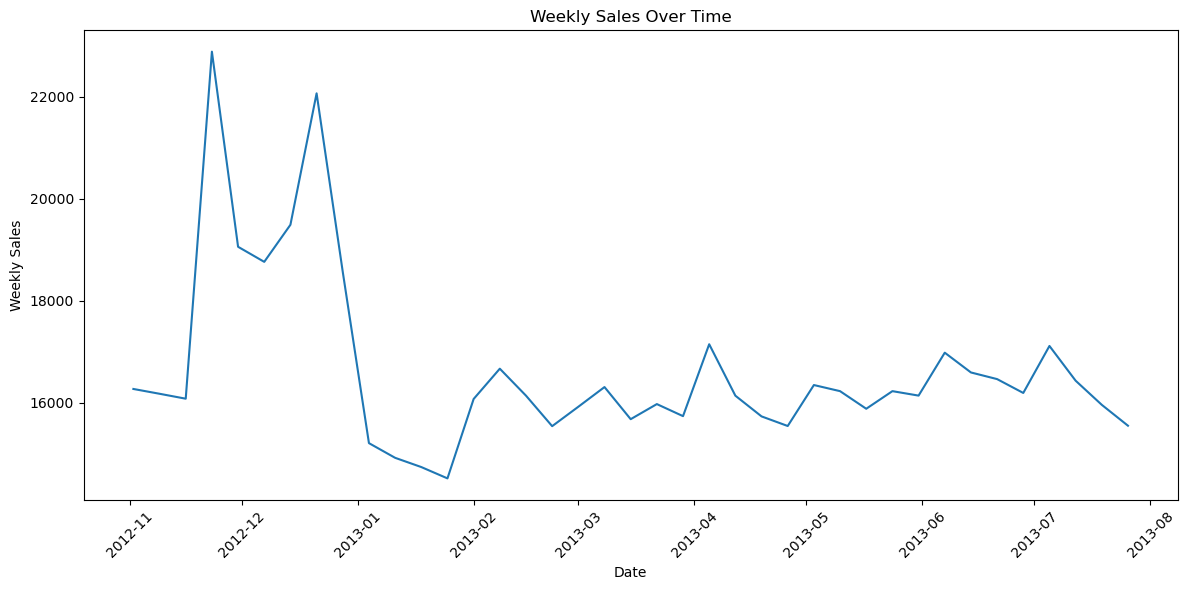

In [50]:
testdata_pred = RandomForest_fixmodel.predict(X_test)
ts_data = pd.DataFrame({'Date': data_test['Date'], 'weekly_sales': testdata_pred})
ts_data['Date'] = pd.to_datetime(ts_data['Date'])
plt.figure(figsize=(12,6))
sns.lineplot(data=ts_data, x='Date', y='weekly_sales', ci=None)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


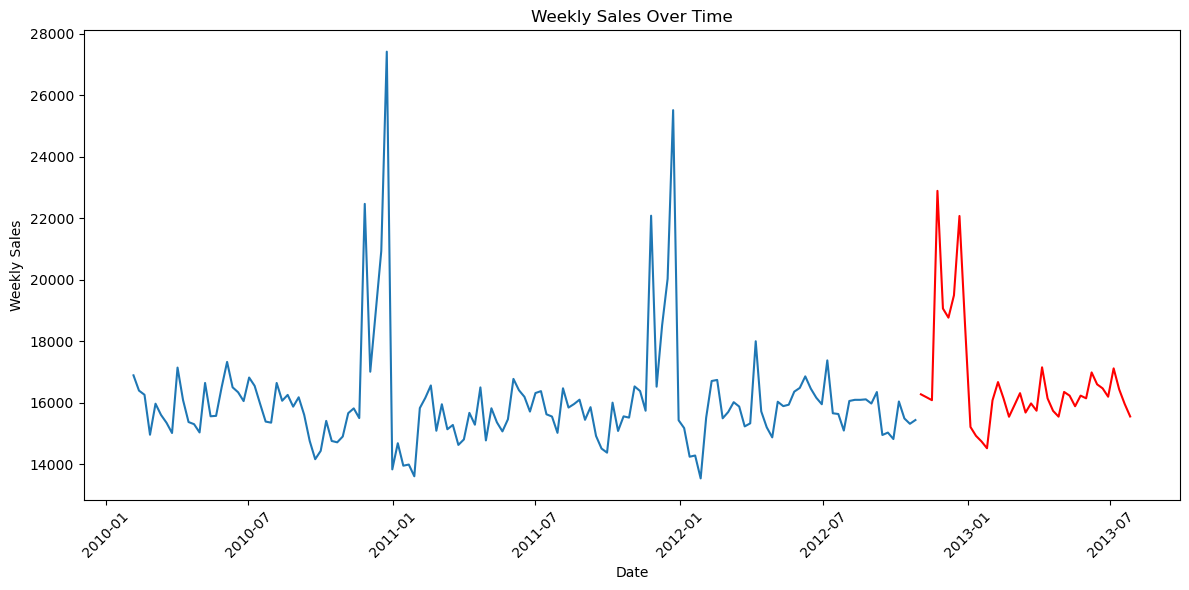

In [51]:
custom_palette = sns.color_palette("muted", n_colors=len(data['Year'].unique()))
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Weekly_Sales', ci=None, palette=custom_palette)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time')
sns.lineplot(data=ts_data, x='Date', y='weekly_sales', ci=None, color='red')
plt.xlabel('Date')
plt.ylabel('Weekly Sales') 
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


## Recommendation

Implement a plan centered on Christmas and Thanksgiving, including inventory, marketing, and staffing adjustments to maximize peak holiday sales.